In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate binary click data for Version A (15 samples, p=0.6) and Version B (19 samples, p=0.4)
x = np.random.binomial(n=1, p=0.6, size=15)  # Version A: higher click probability
y = np.random.binomial(n=1, p=0.4, size=19)  # Version B: lower click probability

# Count number of clicks (1s) and no clicks (0s) for each version
_, (a, c) = np.unique(x, return_counts=True)  # a = clicks, c = no clicks for A
_, (b, d) = np.unique(y, return_counts=True)  # b = clicks, d = no clicks for B

# Create a contingency table of counts
df = pd.DataFrame(data=[[a, b], [c, d]],
                 index=["click", "no click"],
                 columns=["A", "B"])  # Build the contingency table
m = df.values  # Extract the matrix values

# Print the observations
print("- Observations:")
print(f"  - Version A: = {x}")  # Show data for A
print(f"  - Version B: = {y}")  # Show data for B
print("")

# Print the contingency table
print("- Contingency table:")
display(df)  # Nicely show the table in notebook (Jupyter/Colab)


- Observations:
  - Version A: = [1 0 0 1 1 1 1 0 0 0 1 0 0 1 1]
  - Version B: = [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

- Contingency table:


,A,B
click,7,15
no click,8,4


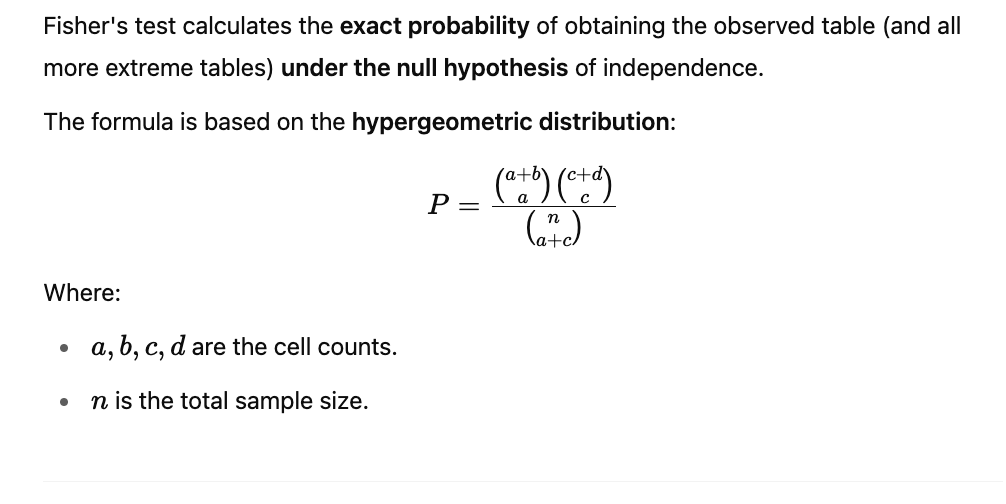

In [ ]:
def hypergeom(k, K, n, N):
    """Probability mass funciton of the hypergeometric distribution."""
    return binom(K, k) * binom(N-K, n-k) / binom(N, n)


def fisher_prob(m):
    """Calculate the probability of observing a given contingency table m under Fisher's exact test."""
    ((a, b), (c, d)) = m  # Unpack table into counts
    k = a         # observed successes in sample
    K = a + b     # total from row 1 (marginal total) - number of successes in the population
    n = a + c     # total from column 1 (marginal total) - sample size
    N = a + b + c + d  # total sample size - population size
    return hypergeom(k, K, n, N)  # Calculate hypergeometric probability

def fisher_probs_histogram(m):
    """Computes prob mass function histogram accroding to Fisher's exact test."""
    neg_val = -min(m[0,0], m[1,1])
    pos_val = min(m[1,0], m[1,0])
    probs = []
    for k in range(neg_val, pos_val+1):
        m1 = m + np.array([[1, -1], [-1, 1]]) * k
        probs.append(fisher_prob(m1))
    return probs

bars_h = np.array(fisher_probs_histogram(m))

f, ax = plt.subplots(figsize=(6, 3))
ii = np.arange(len(bars_h))
ax.bar(ii, bars_h)
idxs = bars_h <= fisher_prob(m)
ax.bar(ii[idxs], bars_h[idxs], color='r')
ax.set_ylabel("prob density")
p_val = bars_h[idxs].sum()
neg_val = -min(m[0,0], m[1,1])
pos_val = min(m[1,0], m[1,0])
ax.bar(ii[-neg_val], bars_h[-neg_val], color='orange')

ax.set_xticks(ii)
ax.set_xticklabels(np.arange(neg_val, pos_val+1))
f.tight_layout()
print(f"- Fisher's exact test: p-val = {100*p_val:.1f}%")

- Fisher's exact test: p-val = 7.5%


In [4]:
from scipy.stats import chi2_contingency

# Perform Pearson's Chi-squared test of independence
# Input: contingency table m (2x2)
# `correction=False` disables Yates' continuity correction (used for small samples)
chi2_val, p_val = chi2_contingency(m, correction=False)[:2]  # Extract test statistic and p-value

# Print the test results
print("- Pearson's chi-squared t-test:")
print(f"   - χ2 value: {chi2_val:.3f}")         # Chi-squared test statistic
print(f"   - p-value: {p_val*100:.1f}%")        # p-value as percentage


- Pearson's chi-squared t-test:
   - χ2 value: 3.825
   - p-value: 5.1%


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed for reproducibility
np.random.seed(42)

# Define sample sizes for Version A (x) and Version B (y)
n_x, n_y = 17, 14

# Define normal distributions for purchase amounts
# Version A: mean = $200, std = $100
# Version B: mean = $280, std = $90
d1 = norm(loc=200, scale=100)
d2 = norm(loc=280, scale=90)

# Discretize the purchase values to nearest multiple of 50
disc = 50
x = (d1.rvs(size=n_x) / disc).astype(int) * disc  # Sample and round Version A
y = (d2.rvs(size=n_y) / disc).astype(int) * disc  # Sample and round Version B

# Print observed purchase values for both versions
print("- Observations:")
print(f"  - Version A: = {x}")  # Version A observations
print(f"  - Version B: = {y}")  # Version B observations
print("")

# Plot the distribution of purchases
print(f"- Distribution plot:")
f, ax = plt.subplots(figsize=(6, 3))  # Create a figure and axis for the plot

# Loop through both datasets to plot side-by-side histograms
for i, (x_, l_, c_) in enumerate(zip([x, y], ["A", "B"], ["tab:blue", "tab:olive"])):
    v, c = np.unique(x_, return_counts=True)  # Get unique purchase values and their counts
    ax.bar(v - 5 + 10*i, c, width=10, label=l_, color=c_)  # Offset bars for visual clarity

# Label plot axes
ax.set_xlabel("purchase in $")
ax.set_ylabel("count")
ax.legend();  # Add legend to distinguish versions


- Observations:
  - Version A: = [200 150 250 350 150 150 350 250 150 250 150 150 200   0   0 100  50]
  - Version B: = [300 150 150 400 250 250 150 200 250 150 300 200 250 200]

- Distribution plot:


In [8]:
def plot_pval(distribution, t_val, xlims=(-5, 5), ylims=(0, 0.5)):
    """Visualize the p-value region on a probability density function curve.

    Parameters:
        distribution: a scipy.stats distribution object (e.g., norm, t)
        t_val: observed test statistic (e.g., from t-test or z-test)
        xlims: tuple indicating the range of x-axis
        ylims: tuple indicating the range of y-axis

    Returns:
        A matplotlib figure and axis with the plot showing the test statistic and p-value area.
    """

    # Generate x-axis values for plotting the PDF
    xxx = np.linspace(*xlims, 1000)

    # Create figure and axis
    f, ax = plt.subplots(figsize=(4, 3))

    # Plot the probability density function of the distribution
    ax.plot(xxx, distribution.pdf(xxx))

    # Set vertical axis limits
    ax.set_ylim(ylims)

    # Draw vertical line at observed test statistic (t_val)
    ax.vlines(t_val, 0, distribution.pdf(t_val), color='orange')

    # Highlight the point on the curve
    ax.plot(t_val, distribution.pdf(t_val), 'o', color='orange')

    # Fill the left tail area (<= t_val)
    xp = xxx <= t_val
    ax.fill_between(xxx[xp], 0, distribution.pdf(xxx[xp]), color='r')  # left tail

    # Fill the right tail area (>= -t_val) — for two-tailed test symmetry
    xp = xxx >= -t_val
    ax.fill_between(xxx[xp], 0, distribution.pdf(xxx[xp]), color='r')  # right tail

    # Label y-axis
    ax.set_ylabel("prob density")

    # Adjust layout
    f.tight_layout()

    return f, ax


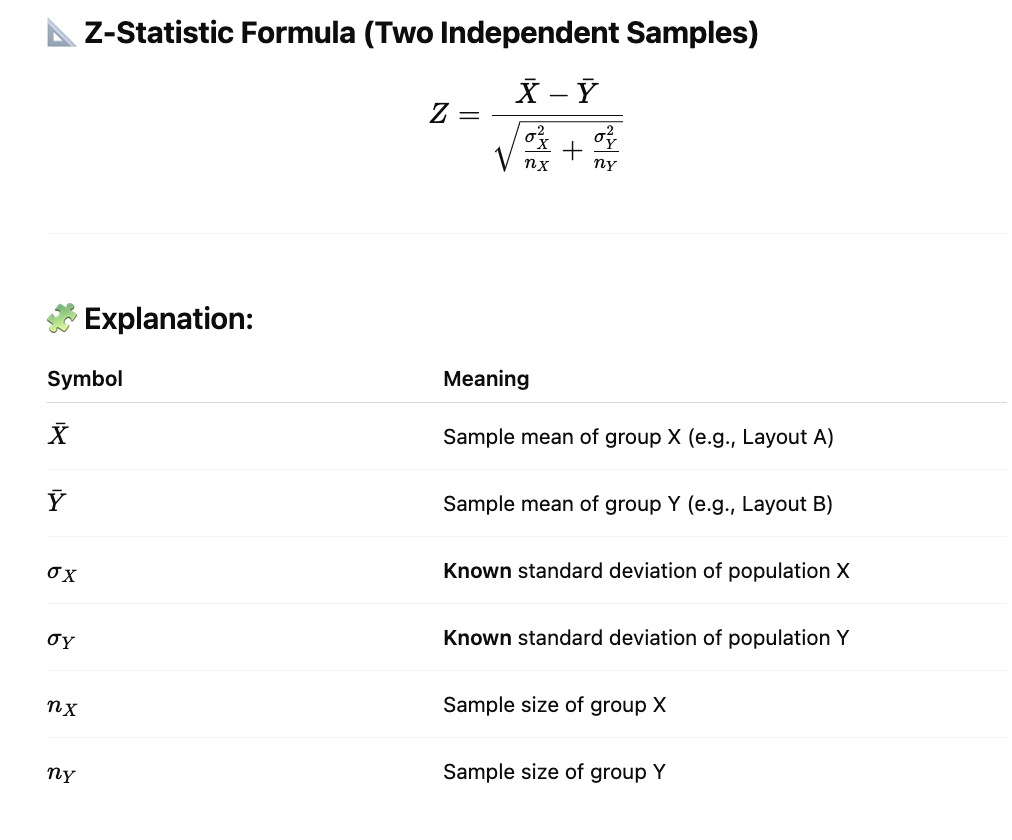

- Z-test:
   - z value: -1.697
   - p-value: 9.0%


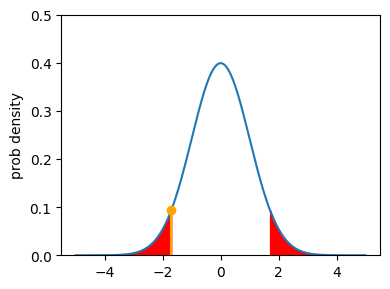

In [17]:
# Known standard deviations
s_x = 100
s_y = 90

# Z value
z_val = (x.mean() - y.mean()) / np.sqrt(s_x**2/n_x + s_y**2/n_y)

# Test statistic distribution under null hypothesis H0
stat_distrib = norm(loc=0, scale=1)

# p-value
p_val = stat_distrib.cdf(z_val) * 2

print("- Z-test:")
print(f"   - z value: {z_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

#Positive z-value → mean of A > mean of B
#Negative z-value → mean of A < mean of
#|z| ≈ 1 – 2 → small difference
#|z| ≈ 2 – 3 → moderate evidence
#|z| > 3 → strong evidence

- Student's t-test:
   - nu: 29.000
   - t value: -1.789
   - p-value: 8.4%


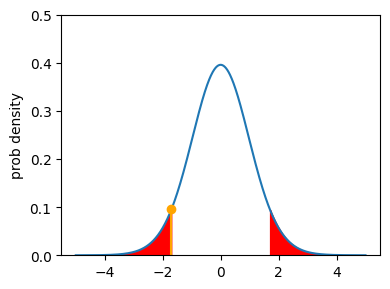

In [18]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Pooled variance
s_p = np.sqrt(((n_x-1) * s_x**2 +
               (n_y-1) * s_y**2)
              / (n_x + n_y - 2))

# Test statistic distribution under null hypothesis H0
dofs = n_x + n_y - 2
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / (s_p * np.sqrt(1/n_x + 1/n_y))

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Student's t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);

- Welch' t-test:
   - nu: 28.505
   - t value: -1.848
   - p-value: 7.5%


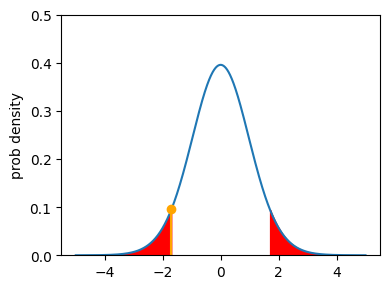

In [ ]:
# Sample variances (w. Bessel correction)
s_x = np.sqrt(np.var(x, ddof=1))
s_y = np.sqrt(np.var(y, ddof=1))

# Denominator (not a pooled variance!)
s_d = np.sqrt(s_x**2/n_x + s_y**2/n_y)


# Test statistic distribution under null hypothesis H0
dofs = s_d**4 / ((s_x**2/n_x)**2/(n_x-1) +
                 (s_y**2/n_y)**2/(n_y-1))
stat_distrib = t(df=dofs, loc=0, scale=1)

# t value
t_val = (x.mean() - y.mean()) / s_d

# p-value
p_val = stat_distrib.cdf(t_val) * 2

print("- Welch' t-test:")
print(f"   - nu: {dofs:.3f}")
print(f"   - t value: {t_val:.3f}")
print(f"   - p-value: {p_val*100:.1f}%")
plot_pval(stat_distrib, z_val);


In [ ]:
mwu = mannwhitneyu(x, y, use_continuity=False, alternative="two-sided")

print("- Mann-Whitney U test:")
print(f"   - U value: {mwu.statistic:.3f}")
print(f"   - p-value: {mwu.pvalue*100:.1f}%")


- Mann-Whitney U test:
   - U value: 76.000
   - p-value: 8.0%


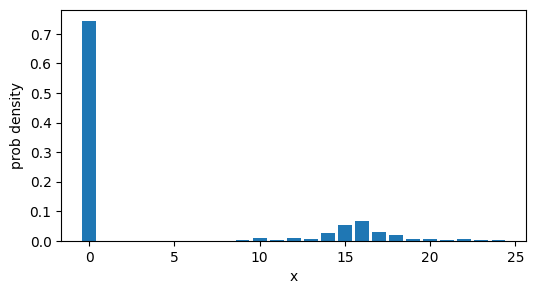

In [ ]:
p = np.array([245, 0, 0, 0, 0, 0, 0, 0, 0,  1, 3, 1, 3, 2, 9, 18, 22, 10, 6, 2, 2, 1, 2, 1, 1])
a = np.arange(len(p))
p = p / p.sum()

f, ax = plt.subplots(figsize=(6, 3))
ax.bar(a, p)
ax.set_ylabel("prob density")
ax.set_xlabel("x");

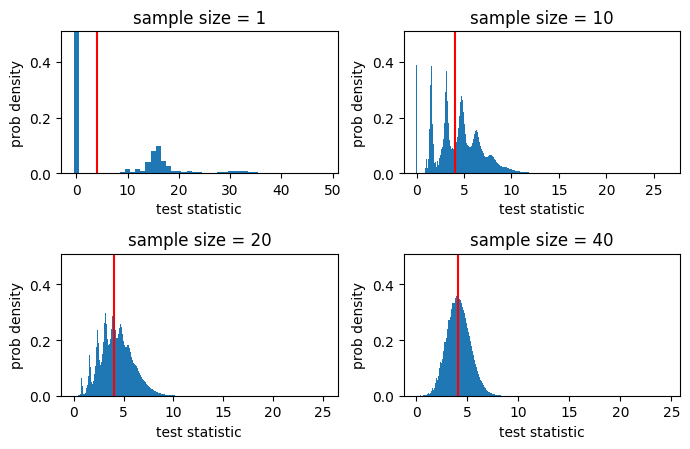

In [ ]:
loc = (p*np.arange(len(p))).sum()

nn = [1, 10, 20, 40]
f, axx = plt.subplots(2, 2, figsize=(3.5*2, 2.3*2))

for i, n in enumerate(nn):
    r, c = divmod(i, 2)
    x = p
    ax = axx[r, c]
    for _ in range(n):
        x = np.convolve(x, p)

    ax.bar(np.arange(len(x))/n, x*n, width=1/n)
    ax.set_ylim([0, 0.51])
    ax.vlines(loc, 0, 0.51, 'r')
    ax.set_xlabel("test statistic")
    ax.set_ylabel("prob density")
    ax.set_title(f"sample size = {n}")

f.tight_layout()